#**1. Eksplorasi Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import warnings
warnings.filterwarnings("ignore")

##**1.1 Load Data**

In [ ]:
path = '/content/ESP32 DataLogging_SIC5_34.csv'
df = pd.read_csv(path)

##**1.2 Informasi Umum Dataset**

###**a. Informasi Tipe Data**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66628 entries, 0 to 66627
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Time  66628 non-null  object 
 1   Humidity       66628 non-null  int64  
 2   Temperature    66628 non-null  float64
 3   CO2            66628 non-null  float64
 4   CO             66628 non-null  float64
 5   PM2.5 Density  66628 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 3.1+ MB
None


###**b. Konversi Tipe Data**

In [ ]:
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

###**c. Visualisasi Data Awal**

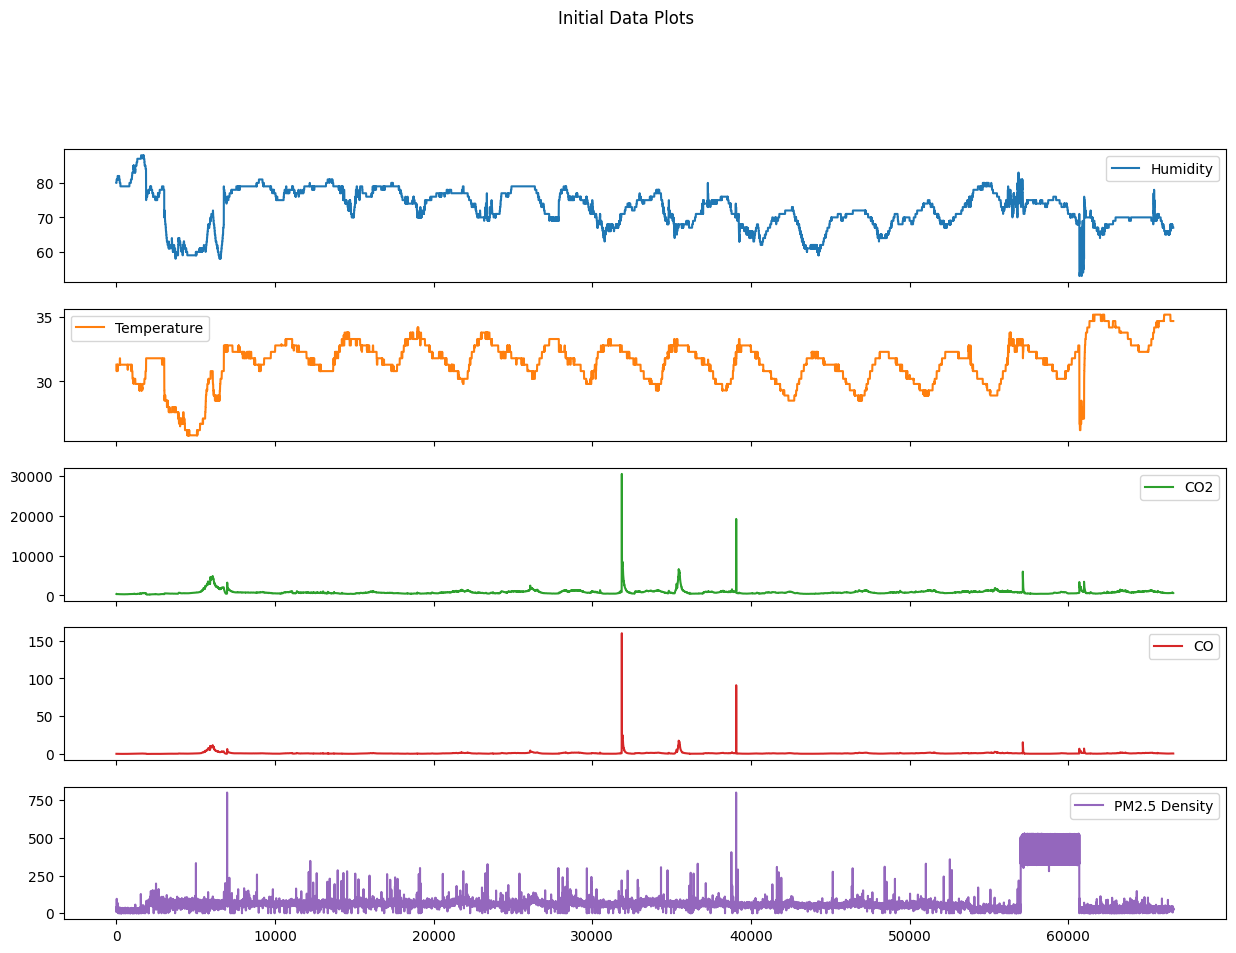

In [ ]:
columns_to_plot = df.columns[df.columns != 'Date and Time']

df[columns_to_plot].plot(subplots=True, figsize=(15, 10))
plt.suptitle('Initial Data Plots', y=1.02)
plt.show()

#**2. Pre Processing Data**

##**2.1 Mengkategorikan Waktu Dalam Sehari.**

In [ ]:
def categorize_time_of_day(hour):
    if 3 <= hour < 12:
        return 'Pagi'
    elif 12 <= hour < 15:
        return 'Siang'
    elif 15 <= hour < 18:
        return 'Sore'
    else:
        return 'Malam'

df['Time of Day'] = df['Date and Time'].dt.hour.apply(categorize_time_of_day)

##**2.2 Mengelompokkan Data dan Menentukan Nilai Minimum**

In [ ]:
df['Date'] = df['Date and Time'].dt.date
grouped = df.groupby(['Date', 'Time of Day']).mean().reset_index()

features = ['Humidity', 'Temperature', 'CO2', 'CO', 'PM2.5 Density']
min_values = grouped[features].min()


#**3. Pembangunan Model**

##**3.1 SARIMA Forecast Function**

In [ ]:
def sarima_forecast(data, order, seasonal_order, steps, min_value):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_mean = np.maximum(forecast_mean, min_value)  # Set forecast mean to min_value if negative

    return forecast_mean

##**3.2 Fit SARIMA dan Membuat Prediksi**

In [ ]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 4)  # Seasonal pattern every 4 time points

predictions = pd.DataFrame()

for feature in features:
    feature_data = grouped.set_index('Date')[feature]
    min_value = min_values[feature]
    forecast_mean = sarima_forecast(feature_data, order, seasonal_order, steps=4, min_value=min_value)  # Predict for next 4 time points
    predictions[feature] = forecast_mean

future_dates = pd.date_range(start=grouped['Date'].max() + pd.Timedelta(days=1), periods=4, freq='D')
future_time_of_day = ['Pagi', 'Siang', 'Sore', 'Malam']
predictions['Date'] = future_dates.repeat(4)[:len(predictions)]
predictions['Time of Day'] = future_time_of_day * (len(predictions) // 4)


##**3.3 Kalkulasi Air Quality**

In [ ]:
def calculate_aqi(concentration, breakpoints):
    for (ConcLow, ConcHigh, IndexLow, IndexHigh) in breakpoints:
        if ConcLow <= concentration <= ConcHigh:
            return ((IndexHigh - IndexLow) / (ConcHigh - ConcLow)) * (concentration - ConcLow) + IndexLow
    return None

def categorize_air_quality(row):
    pm25 = row['PM2.5 Density']
    co = row['CO']
    co2 = row['CO2']

    pm25_breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500)
    ]

    co_breakpoints = [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500)
    ]

    co2_breakpoints = [
        (0.0, 1000, 0, 50),
        (1001, 2000, 51, 100),
        (2001, 3000, 101, 150),
        (3001, 4000, 151, 200),
        (4001, 5000, 201, 300),
        (5001, 6000, 301, 400),
        (6001, 10000, 401, 500)
    ]

    pm25_aqi = calculate_aqi(pm25, pm25_breakpoints)
    co_aqi = calculate_aqi(co, co_breakpoints)
    co2_aqi = calculate_aqi(co2, co2_breakpoints)

    aqi_values = [value for value in [pm25_aqi, co_aqi, co2_aqi] if value is not None]
    if not aqi_values:
        return 'Tidak Tersedia'

    overall_aqi = max(aqi_values)

    if overall_aqi <= 100:
        return 'Baik'
    elif 101 <= overall_aqi <= 200:
        return 'Sedang'
    else:
        return 'Buruk'

predictions['Air Quality'] = predictions.apply(categorize_air_quality, axis=1)


#**4. Hasil Prediksi dan Evaluasi**

In [ ]:
grouped['Air Quality'] = grouped.apply(categorize_air_quality, axis=1)

print("Data Asli Terakhir:")
print(grouped.tail(5))

Data Asli Terakhir:
          Date Time of Day                 Date and Time   Humidity  \
66  2024-07-20        Sore 2024-07-20 16:30:23.281425920  66.150094   
67  2024-07-21       Malam 2024-07-21 01:29:56.000000000  69.772222   
68  2024-07-21        Pagi 2024-07-21 07:29:55.720987648  70.104321   
69  2024-07-21       Siang 2024-07-21 13:29:55.000000000  67.437037   
70  2024-07-21        Sore 2024-07-21 15:56:45.000000000  66.730205   

    Temperature         CO2        CO  PM2.5 Density Air Quality  
66    34.873358  582.458437  0.642979      29.524978        Baik  
67    33.300556  830.959234  1.046894      33.306338        Baik  
68    33.010864  953.740619  1.259389      34.845820        Baik  
69    34.924444  639.813267  0.728607      31.257118        Baik  
70    34.935777  582.130909  0.638001      30.351113        Baik  


In [ ]:
ordered_columns = ['Date', 'Time of Day'] + [col for col in predictions.columns if col not in ['Date', 'Time of Day']]
predictions = predictions[ordered_columns]

print("Data Prediksi Masa Depan (1 hari kedepan):")
print(predictions)

Data Prediksi Masa Depan (1 hari kedepan):
          Date Time of Day   Humidity  Temperature         CO2        CO  \
71  2024-07-22        Pagi  66.026024    36.670667  706.464905  1.083305   
72  2024-07-22       Siang  66.816940    36.416882  645.338896  0.694181   
73  2024-07-22        Sore  68.156975    36.682754  712.018627  0.854916   
74  2024-07-22       Malam  67.594825    35.119946  879.877527  1.078132   

    PM2.5 Density Air Quality  
71      27.513446        Baik  
72      43.219497      Sedang  
73      56.274642      Sedang  
74      29.733320        Baik  


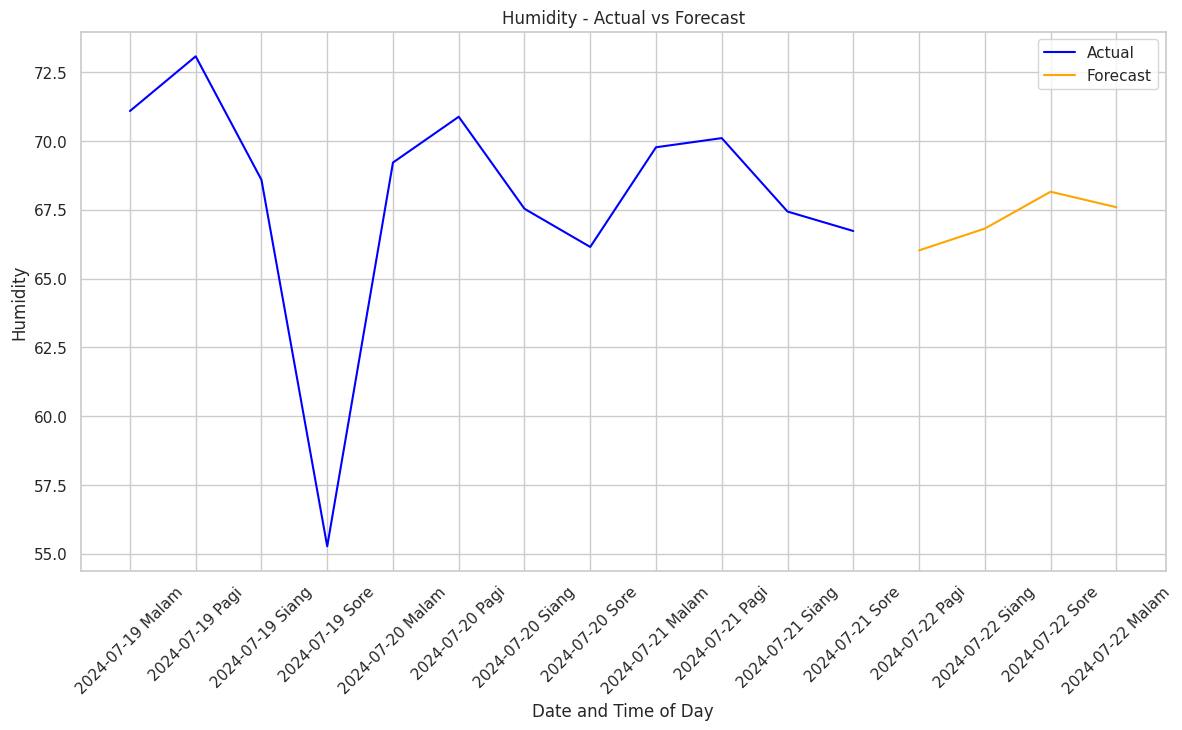

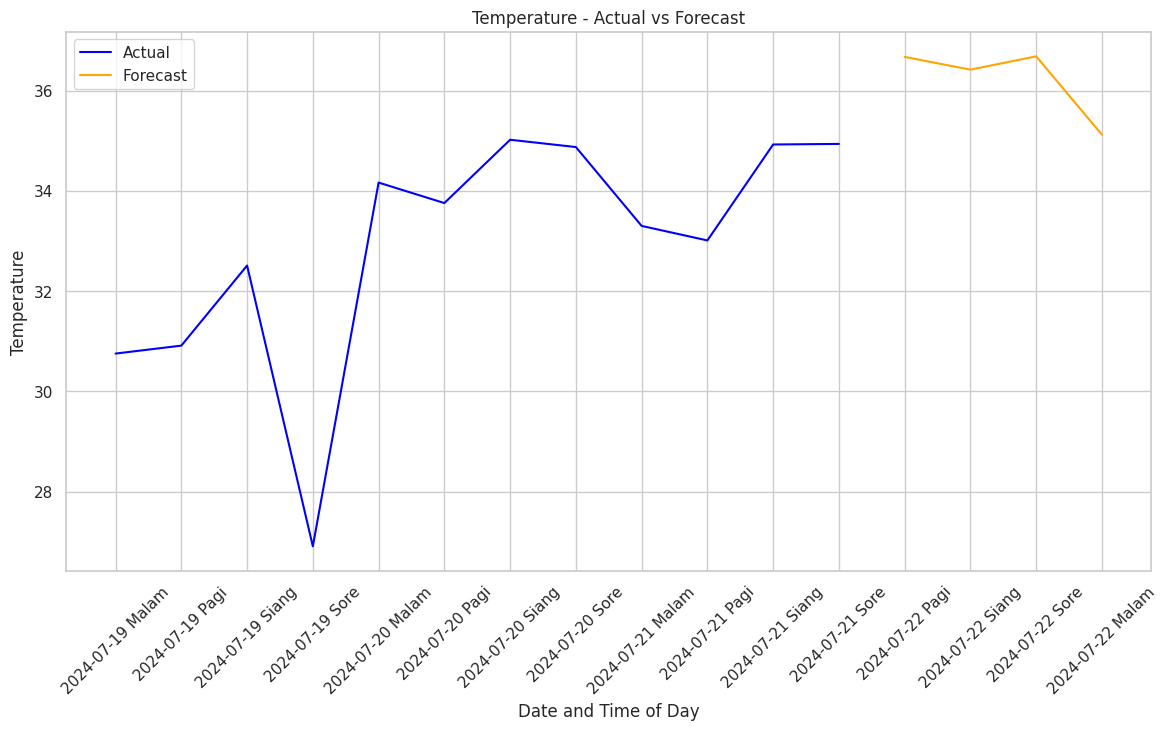

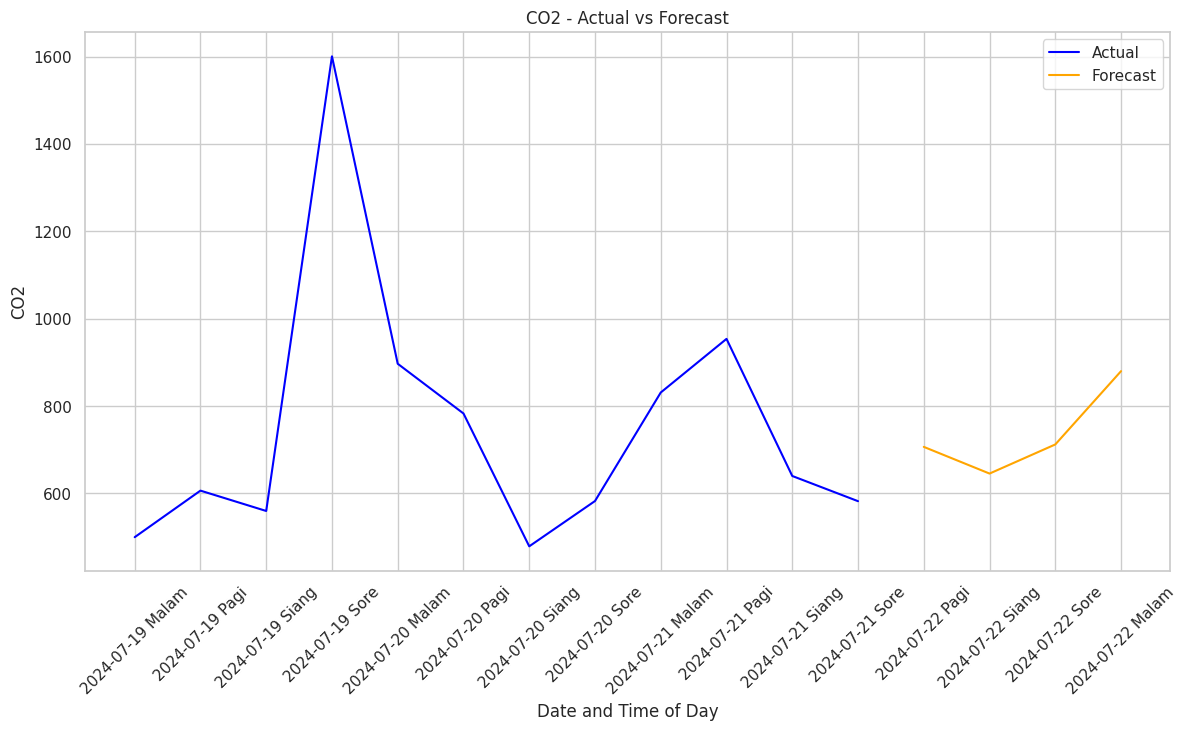

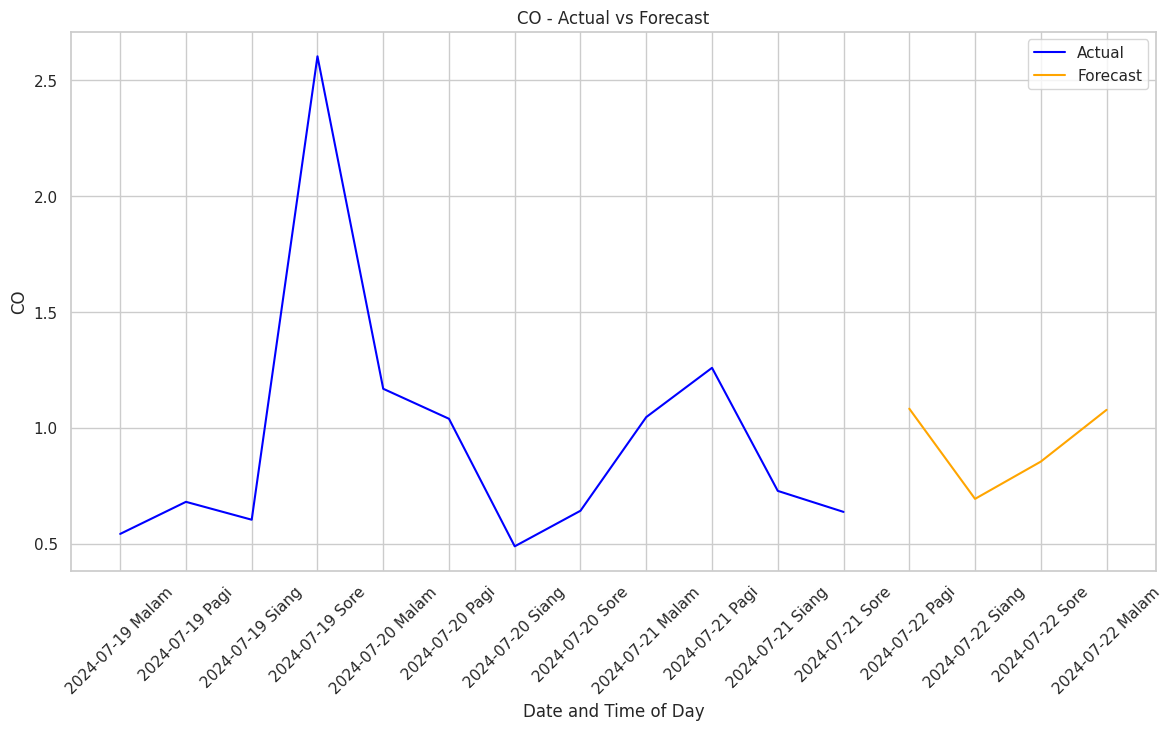

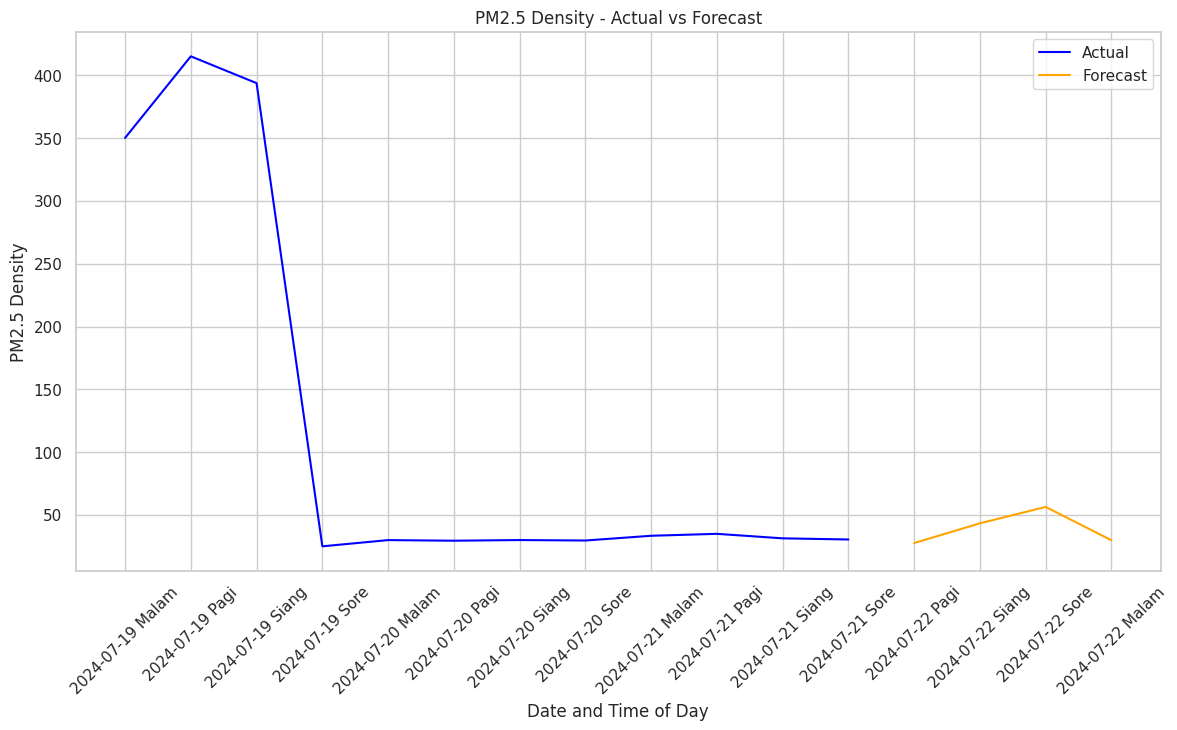

In [ ]:
daily_grouped = grouped.groupby('Date')[features].mean().reset_index()
sns.set(style="whitegrid")

last_3_days = grouped['Date'].unique()[-3:]
filtered_actual = grouped[grouped['Date'].isin(last_3_days)]

def plot_forecast(actual, forecast, feature, date_col='Date', time_of_day_col='Time of Day'):
    plt.figure(figsize=(14, 7))

    actual_dates = actual[date_col].astype(str) + " " + actual[time_of_day_col]
    plt.plot(actual_dates, actual[feature], label='Actual', color='blue')

    forecast_dates = forecast[date_col].astype(str) + " " + forecast[time_of_day_col]
    plt.plot(forecast_dates, forecast[feature], label='Forecast', color='orange')

    plt.xticks(rotation=45)
    plt.xlabel('Date and Time of Day')
    plt.ylabel(feature)
    plt.title(f'{feature} - Actual vs Forecast')
    plt.legend()
    plt.show()

next_day = (daily_grouped['Date'].max() + pd.Timedelta(days=1))
future_dates = [next_day] * 4
future_times_of_day = ['Pagi', 'Siang', 'Sore', 'Malam']

predictions['Date'] = future_dates
predictions['Time of Day'] = future_times_of_day

for feature in features:
    plot_forecast(filtered_actual, predictions, feature)

In [ ]:
# Fungsi untuk menghitung MAPE
def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)  # Menghindari pembagian dengan nol
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Menghitung MAE, MSE, RMSE, dan MAPE untuk setiap fitur (dengan koreksi untuk MAPE)
error_metrics = {}

for feature in features:
    actual_values = df_actual[feature]
    predicted_values = predictions[feature]

    mae_value = mean_absolute_error(actual_values, predicted_values)
    mse_value = mean_squared_error(actual_values, predicted_values)
    rmse_value = rmse(actual_values, predicted_values)
    mape_value = mape(actual_values, predicted_values)

    error_metrics[feature] = {
        'MAE': mae_value,
        'MSE': mse_value,
        'RMSE': rmse_value,
        'MAPE': mape_value
    }

# Menghitung MAE, MSE, RMSE, dan MAPE untuk nilai AQI (dengan koreksi untuk MAPE)
actual_aqi_numeric = actual_aqi.map(aqi_mapping).dropna()
predicted_aqi_numeric = predicted_aqi.map(aqi_mapping).dropna()

min_length = min(len(actual_aqi_numeric), len(predicted_aqi_numeric))
actual_aqi_numeric = actual_aqi_numeric[:min_length]
predicted_aqi_numeric = predicted_aqi_numeric[:min_length]

aqi_mae = mean_absolute_error(actual_aqi_numeric, predicted_aqi_numeric)
aqi_mse = mean_squared_error(actual_aqi_numeric, predicted_aqi_numeric)
aqi_rmse = rmse(actual_aqi_numeric, predicted_aqi_numeric)
aqi_mape = mape(actual_aqi_numeric, predicted_aqi_numeric)

error_metrics['AQI'] = {
    'MAE': aqi_mae,
    'MSE': aqi_mse,
    'RMSE': aqi_rmse,
    'MAPE': aqi_mape
}

# Menampilkan hasil
for feature, metrics in error_metrics.items():
    print(f"{feature}:")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  RMSE: {metrics['RMSE']}")
    print(f"  MAPE: {metrics['MAPE']}\n")


Humidity:
  MAE: 0.003377470969522752
  MSE: 1.5667287523481377e-05
  RMSE: 0.003958192456599524
  MAPE: 0.005041001447048883

Temperature:
  MAE: 0.0014882143872204285
  MSE: 3.03619107225473e-06
  RMSE: 0.0017424669501183458
  MAPE: 0.0042888022686467684

CO2:
  MAE: 7.900420263317652
  MSE: 94.62265284933818
  RMSE: 9.72741758378544
  MAPE: 1.3084201743096753

CO:
  MAE: 0.016349412633328776
  MSE: 0.00032233655083777123
  RMSE: 0.017953733618324943
  MAPE: 2.4662476868498104

PM2.5 Density:
  MAE: 4.715040367844193
  MSE: 30.378336433338266
  RMSE: 5.511654600329947
  MAPE: 19.695744324597698

AQI:
  MAE: 0.08333333333333333
  MSE: 0.08333333333333333
  RMSE: 0.28867513459481287
  MAPE: 4.166666666666666



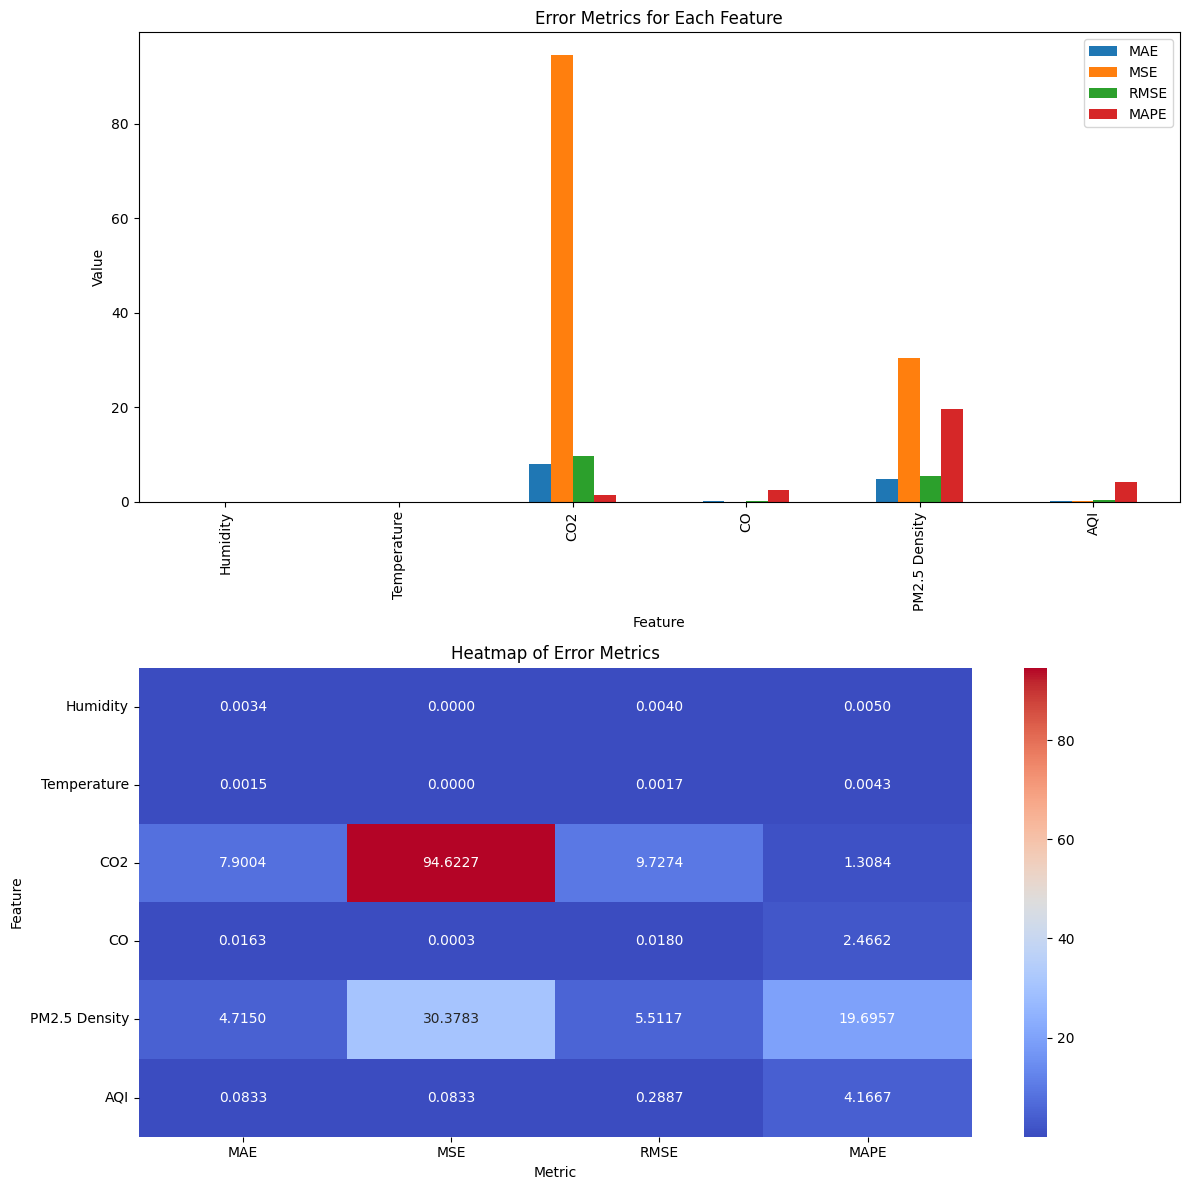

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat DataFrame untuk visualisasi
import pandas as pd

# Convert error_metrics dictionary to DataFrame
metrics_df = pd.DataFrame(error_metrics).T

# Plotting Bar Chart
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Bar chart for MAE, MSE, RMSE, MAPE
metrics_df.plot(kind='bar', ax=ax[0])
ax[0].set_title('Error Metrics for Each Feature')
ax[0].set_ylabel('Value')
ax[0].set_xlabel('Feature')
ax[0].legend(loc='upper right')

# Heatmap for all metrics
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt='.4f', ax=ax[1])
ax[1].set_title('Heatmap of Error Metrics')
ax[1].set_ylabel('Feature')
ax[1].set_xlabel('Metric')

plt.tight_layout()
plt.show()
